# **Prediksi Konsentrasi NO₂ di Kabupaten Bojonegoro dengan KNN Regression**

## **Tahap Pengumpulan Data Penjelasan**

Data yang digunakan adalah konsentrasi gas Nitrogen Dioksida (NO₂) hasil observasi satelit Sentinel-5P yang disediakan melalui platform Copernicus OpenEO.


Rentang waktu pengambilan data: 1 Juni 2025 – 19 Oktober 2025, menghasilkan data harian rata-rata konsentrasi NO₂.

Data diambil untuk wilayah Kabupaten Bojonegoro, dengan batas koordinat poligon berikut:

Data NO₂ diambil dari produk Sentinel-5P Level-2 (S5P L2) melalui platform Copernicus/OpenEO. Sentinel-5P membawa instrumen TROPOMI yang mengukur kolom gas atmosfer (mis. NO₂, O₃). Produk L2 menyajikan pengukuran pada grid spasial yang relatif halus untuk skala regional. Saat mengambil data melalui OpenEO kita perlu:

Memilih koleksi yang tepat: pastikan SENTINEL_5P_L2 benar-benar berisi band NO2 (atau nama band sesuai documentasi layanan). Produk L2 biasanya mengandung metadata quality (mis. QA_value) yang bisa dipakai untuk filter pengukuran berkepercayaan rendah.

Spasial AOI: gunakan polygon yang mewakili batas wilayah (di sini kotak di Bojonegoro). Penting memeriksa apakah AOI terlalu kecil sehingga jumlah piksel valid sedikit, yang dapat meningkatkan noise.

Temporal extent: tentukan rentang tanggal (1 Juni — 19 Okt 2025). Frekuensi TROPOMI harian, tapi ada kasus data cloud/qa mengurangi observasi valid di beberapa hari — oleh karena itu agregasi harian dan pengecekan missing penting.

Masking & quality filtering: beberapa piksel memiliki nilai negatif atau flagged sebagai invalid (mis. cloud cover, low QA). Langkah mask untuk menghapus nilai < 0 perlu digabungkan jika tersedia filter QA_value dari produk agar tidak menggunakan data beresiko.

Agregasi: kita mengambil rata-rata temporal per hari lalu rata-rata spasial di dalam AOI. Ini menghasilkan seri waktu harian (satu nilai NO₂ per hari) yang lebih mudah diolah ketimbang citra penuh.

Catatan operasional: saat menjalankan batch job di OpenEO, perhatikan kuota, ukuran job, dan nama output — serta cek log job untuk error/timeout.

In [ ]:
# ==========================
# Tahap 1: Pengumpulan Data
# ==========================
import openeo
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Autentikasi ke platform OpenEO Copernicus
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# Area of Interest (AOI)
aoi_geojson = {
    "type": "Polygon",
    "coordinates": [[
        [111.84013944486253, -7.112176997696622],
        [111.84013944486253, -7.201964283327371],
        [111.93244545164555, -7.201964283327371],
        [111.93244545164555, -7.112176997696622],
        [111.84013944486253, -7.112176997696622]
    ]]
}

# Ambil data NO₂ Sentinel-5P
s5post = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2025-06-01", "2025-10-19"],
    spatial_extent={"west": 111.84013944486253, "south": -7.201964283327371,
                    "east": 111.93244545164555, "north": -7.112176997696622},
    bands=["NO2"]
)

# Masking nilai negatif
def mask_invalid(x):
    return x < 0

s5p_masked = s5post.mask(s5post.apply(mask_invalid))

# Agregasi harian dan spasial
daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")
daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi_geojson, reducer="mean")

# Eksekusi batch dan unduh hasil dalam format CSV
job = daily_mean_aoi.execute_batch(out_format="CSV")
results = job.get_results()
results.download_files("no2_bojonegoro_dataset")

# Baca hasil
df = pd.read_csv("no2_bojonegoro_dataset/timeseries.csv")
df["date"] = pd.to_datetime(df["date"])
df["month"] = df["date"].dt.to_period("M")

# Hitung rata-rata bulanan
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

# Visualisasi tren bulanan
plt.figure(figsize=(10,5))
plt.plot(df_monthly["month"].astype(str), df_monthly["NO2"], marker="o", color="blue")
plt.title("Rata-rata Bulanan NO₂ di Bojonegoro (Sentinel-5P)")
plt.xlabel("Bulan")
plt.ylabel("Konsentrasi NO₂")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

    Titik Koordinat Area Observasi Area Bojonegoro

| Titik | Longitude           | Latitude            |
|:-----:|:--------------------|:--------------------|
| 1     | 111.84013944486253  | -7.112176997696622  |
| 2     | 111.84013944486253  | -7.201964283327371  |
| 3     | 111.93244545164555  | -7.201964283327371  |
| 4     | 111.93244545164555  | -7.112176997696622  |
| 5     | 111.84013944486253  | -7.112176997696622  |

    Area ini membentuk sebuah poligon yang mewakili area observasi di wilayah sebagian Kabupaten Bojonegoro.


    0:00:00 Job 'j-25102309191243f3b1a931cec1feb244': send 'start'

    0:00:13 Job 'j-25102309191243f3b1a931cec1feb244': created (progress 0%)

    0:00:19 Job 'j-25102309191243f3b1a931cec1feb244': created (progress 0%)
    
    0:00:25 Job 'j-25102309191243f3b1a931cec1feb244': created (progress 0%)

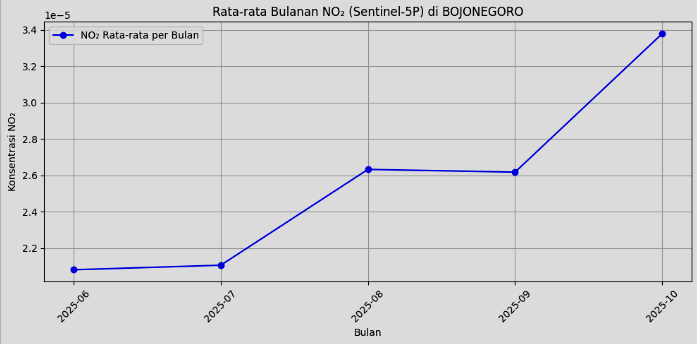

# **Tahap Pra-pemrosesan Data Menangani Nilai Hilang**

Sebanyak 36 nilai hilang ditemukan dalam data.
Untuk mengatasinya digunakan metode interpolasi linear, diikuti dengan forward-fill dan backward-fill agar tidak ada celah data kosong.

In [ ]:
# ==========================
# Tahap 2: Preprocessing
# ==========================
import pandas as pd

data_no2 = pd.read_csv("no2_bojonegoro_dataset/timeseries.csv")
print(data_no2.isnull().sum())

# Interpolasi linear
data_no2["date"] = pd.to_datetime(data_no2["date"])
data_no2.set_index("date", inplace=True)
data_no2["NO2"] = data_no2["NO2"].interpolate(method="linear").ffill().bfill()

# Simpan data bersih
data_no2.to_csv("no2_bojonegoro_dataset/clean_data.csv")
print(data_no2.isnull().sum())
